# Exploring disease in `epydemic`

Let's now put together everything we know about epidemic models on networks, and do some simulations of an epidemic over a network. We'll make use of several things we've seen before:

- the networked SIR model
- random ER networks
- parameters spaces for running experiments in bulk
- everything-as-code, for reproducibility

In [1]:
# numpy
import numpy

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, ParallelLab, JSONLabNotebook
from epydemic import ERNetwork, SIR, StochasticDynamics

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

As before we'll create a notebook and a parallel lab to run our experiments in. The only difference is that we'll not create the notebook if it already exists: instead, we'll load it so any pre-computed result sets are brought in automatically. The we'll see how to execute experiments "conditionally", to create a result set if it doesn't already exist &ndash; but to select it if  it does. With care this can be used to reduce the amount of manual intervention while still avoiding unnecessary simulations

In [2]:
# create a lab notebook backed by a JSON file
# (note that the notebook will be loaded, not overwritten, if it exists already)
nb = JSONLabNotebook(Path(datasets, "09-06-sir.json"))

In [3]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

Current system has 16 cores in total


In [4]:
# pick the number of cores -- change this to change parallelism
nCores = 6

In [5]:
# create the lab
lab = ParallelLab(notebook=nb, cores=nCores)

## The simulation

The trick is that instead of setting up the parameter space for experiments directly, we encapsulate this (and the other setup functions for running an experiment into a function.

In [6]:
def sir_er(lab):
    '''Simulate epidemics across the pInfect space.'''

    # set the disease parameter space
    lab[SIR.P_INFECTED] = 0.001
    lab[SIR.P_INFECT] = numpy.linspace(0.0, 1.0,
                                       num=100)
    lab[SIR.P_REMOVE] = 0.002

    # set the topology for the generated network
    lab[ERNetwork.N] = int(1e4)
    lab[ERNetwork.KMEAN] = 40

    # create the model, network generator, and experiment
    m = SIR()
    g = ERNetwork()
    e = StochasticDynamics(m, g)
    
    # run the experiment
    lab.runExperiment(e)

That's basically the same code as we've used before, but within a function definition. We have some static parameters, and a "range" parameter (actually a `numpy` `linspace`) that sweeps through the range of possible infection probabilities. This parameter space will have 100 parameter sets in it, one for each such infectivity.

Now we'll tell the lab to create a dataset using this function. If a datset with that tag already exists, we'll simply select it as current ready for use; if it doesn't we'll create it and run the construction function to run its experiments and populate it.

In [7]:
lab.createWith("sir_er",     # tag for a resultset
               sir_er,       # function used to create the resultset (if it doesn't exist)
               "SIR epidemic on ER network for different sizes and infectivities")

True

So what was the result? We can plot the results of the final size of the R compartment (recording how many people were infected in total over the course of the epidemic) against the infectivity. First we grab the results into `pandas`.

In [8]:
df = nb.dataframe("sir_er")

Then we can plot them directly using `matplotlib`.

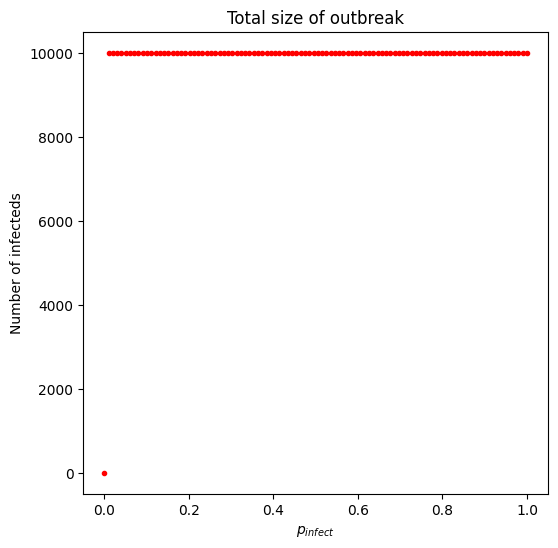

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title('Total size of outbreak')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Number of infecteds')
plt.show()

Hmm... That's not very informative. It looks like there's an epidemic outbreak, covering the whole network, for *every* infection probability. That's possible, of course. But perhaps we should dig deeper.

## Digging deeper

Let's look at the early stages of the epidemic. When $p_{infect} = 0$ we'd obviously expect very little infection: the initial infections will infect no-one else, and then be removed. But at the next value we try, $p_{infect} = 0.01$, we have a *huge* outbreak. Maybe we ought to look in this narrow region to see what's happening.

In [16]:
def sir_er_low(lab):
    '''Simulate the low-infectivity epidemics.'''
    
    # set the disease parameter space
    lab[SIR.P_INFECTED] = 0.001
    lab[SIR.P_INFECT] = numpy.linspace(0.0, 0.01,
                                       num=100)
    lab[SIR.P_REMOVE] = 0.002

    # set the topology for the generated network
    lab[ERNetwork.N] = int(1e4)
    lab[ERNetwork.KMEAN] = 40

    # create the model, network generator, and experiment
    m = SIR()
    g = ERNetwork()
    e = StochasticDynamics(m, g)
    
    # run the experiment
    lab.runExperiment(e)

In [17]:
lab.createWith("sir_er_low",
               sir_er_low,
               "SIR epidemic on ER network, focusing on low infectivity

True

Now we can generate essentially the same plot, but magnifying the early behaviour  of the epidemic.

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_low")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title('Total size of outbreak (early stages)')
ax.set_xlabel('$p_{infect}$')
pInfects = numpy.linspace(0.0, 0.01, num=100)
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
plt.show()

OK, so a steep curve, but not an immediate one: there seem to be some values between no outbreak and a full epidemic.

## Epidemics at very low infectivity

Let's zoom in again, this time focusing on the very low values.

In [25]:
def sir_er_verylow(lab):
    '''Simulate the very low-infectivity epidemics.'''
    
    # set the disease parameter space
    lab[SIR.P_INFECTED] = 0.001
    lab[SIR.P_INFECT] = numpy.linspace(0.0, 0.0002,
                                       num=100)
    lab[SIR.P_REMOVE] = 0.002

    # set the topology for the generated network
    lab[ERNetwork.N] = int(1e4)
    lab[ERNetwork.KMEAN] = 40

    # create the model, network generator, and experiment
    m = SIR()
    g = ERNetwork()
    e = StochasticDynamics(m, g)
    
    # run the experiment
    lab.runExperiment(e)

In [30]:
lab.createWith("sir_er_verylow",
               sir_er_verylow,
               "SIR epidemic on ER network, zoomed right in small infectivity")

True

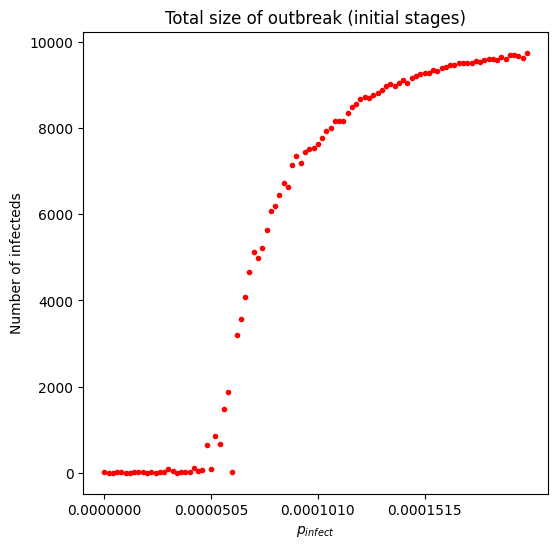

In [29]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_verylow")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title('Total size of outbreak (initial stages)')
ax.set_xlabel('$p_{infect}$')
pInfects = numpy.linspace(0.0, 0.0002, num=100)
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
plt.show()

Now that's *very* different! There's still a very fast take-off of the epidemic size, but it's not instantaneous: there is some structure in the ways in which the sizes change over a very small range of $p_{infect}$ values. But notice that some values of $p_{infect} > 0$ still produce essentially no outbreak, which might not be what we expected.

## Critique

This is quite a powerful approach. Of course there are lots of other things we could have done. We could have simulated the whole space of infectivity at very high resolution, and then zoomed-in to the dataset. But that would be incredibly wasteful of computing time, given that the results from values of $p_{infect} > 0.0002$ look to be the same! So doing a coarse simulation and then refining it is perhaps a better approach.

There are some other things that seem awkward. We defined three different functions to create the three result sets, which differed only by the range of $p_{infect}$ they explored: surely we could do better, perhaps by defining a function that took a parameter range and *returned* a function that could create the data *for that range*? That souild certainly reduce the amount of code, and so the scope for errors.

There are a few more things we can ask as well. Are infectivities this low *always* so sensitive? &ndash; or there some other factor in play, like the network topology, or its size, or its mean degree?

There are quite a lot of parameters we can vary. But each time we do so we increase the number of simulations we do, and the volume of data we collect. It's easy to imagine this getting out of hand, so we need to be careful and think carefully about what *might* affect the results and and how best to *demonstrate* any relationship.